### Explore stroke dataset

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import sys, os
import glob
import nibabel as nib
import cv2
import torch
from tqdm import tqdm
import segmentation_models_pytorch as smp
import random
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split, KFold
import torch.nn.functional as F
from monai.utils import first, set_determinism
from monai.transforms import (
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Resized,
    Resize,
 RandAffined,
 ToTensord,
)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, pad_list_data_collate



In [2]:
data_dir = r"D:\research\Dataset\stroke dataset\ISLES-2022\ISLES-2022"

In [3]:
seg_sample = os.path.join(data_dir, "derivatives", "sub-strokecase0001", "ses-0001", "sub-strokecase0001_ses-0001_msk.nii.gz")
dwi_sample = os.path.join(data_dir, "sub-strokecase0001", "ses-0001", "dwi", "sub-strokecase0001_ses-0001_dwi.nii.gz")
adc_sample = os.path.join(data_dir, "sub-strokecase0001", "ses-0001", "dwi", "sub-strokecase0001_ses-0001_adc.nii.gz")
flair_sample = os.path.join(data_dir, "sub-strokecase0001", "ses-0001", "anat", "sub-strokecase0001_ses-0001_FLAIR.nii.gz")

In [4]:
seg_sample_img_info = nib.load(seg_sample).get_fdata()
print("mask unit voxel size: ", nib.load(seg_sample).header.get_zooms())

dwi_sample_img_info = nib.load(dwi_sample)
print("dwi unit voxel size: ", dwi_sample_img_info.header.get_zooms())

adc_sample_img_info = nib.load(adc_sample)
print("adc unit voxel size: ", adc_sample_img_info.header.get_zooms())

seg_sample_img_info = nib.load(seg_sample)
print("seg unit voxel size: ", seg_sample_img_info.header.get_zooms())

mask unit voxel size:  (2.0, 2.0, 2.0)
dwi unit voxel size:  (2.0, 2.0, 2.0)
adc unit voxel size:  (2.0, 2.0, 2.0)
seg unit voxel size:  (2.0, 2.0, 2.0)


In [5]:
seg_sample_img = nib.load(seg_sample).get_fdata()
dwi_sample_img = nib.load(dwi_sample).get_fdata()
adc_sample_img = nib.load(adc_sample).get_fdata()
flair_sample_img = nib.load(flair_sample).get_fdata()

In [6]:
print("segmentation label shape: ", seg_sample_img.shape)   
print("dwi shape: ", dwi_sample_img.shape)  
print("adc shape: ", adc_sample_img.shape)
print("flair shape: ", flair_sample_img.shape)


segmentation label shape:  (112, 112, 73)
dwi shape:  (112, 112, 73)
adc shape:  (112, 112, 73)
flair shape:  (281, 352, 352)


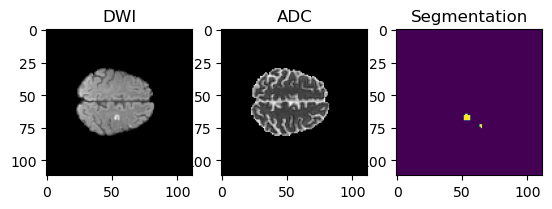

In [8]:
plt.subplot(1, 3, 1)
plt.imshow(dwi_sample_img[:, :, 55], cmap='gray')
plt.title('DWI')

# Second subplot
plt.subplot(1, 3, 2)
plt.imshow(adc_sample_img[:, :, 55], cmap='gray')
plt.title('ADC')

# Third subplot
plt.subplot(1, 3, 3)
plt.imshow(seg_sample_img[:, :, 55])
plt.title('Segmentation')

# Display all subplots
plt.show()


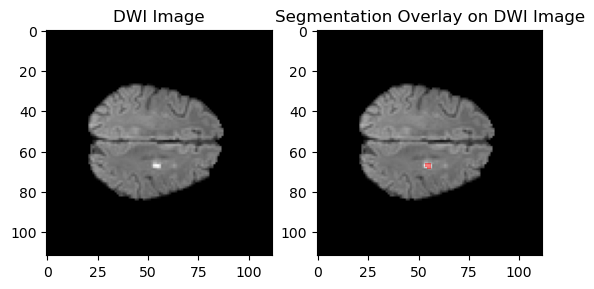

In [8]:
# Plot the DWI image
plt.subplot(1, 2, 1)
plt.imshow(dwi_sample_img[:, :, 50], cmap='gray')
plt.title('DWI Image')

# Plot the segmentation overlay on top of the DWI image
plt.subplot(1, 2, 2)
plt.imshow(dwi_sample_img[:, :, 50], cmap='gray')
mask_ = np.ma.masked_where(seg_sample_img==0, seg_sample_img)
plt.imshow(mask_[:, :, 50], alpha=0.5, cmap='autumn')  # Adjust alpha for transparency
plt.title('Segmentation Overlay on DWI Image')

plt.show()

### Prepare data

In [7]:
all_files = sorted(glob.glob(os.path.join(data_dir, "*sub-strokecase*")))
print("Total files: ", len(all_files))

Total files:  250


In [8]:
all_files[0].split(os.sep)[-1]

'sub-strokecase0001'

In [9]:
# for file in tqdm(all_files, desc="Loading data"):
#         filename = file.split(os.sep)[-1]
#         dwi_file = glob.glob(os.path.join(file, "ses-0001", "dwi", "*dwi.nii.gz"))[0]
       
#         # adc_file = glob.glob(os.path.join(file, "ses-0001", "dwi", "*adc.nii.gz"))[0]
#         # seg_file = glob.glob(os.path.join(data_dir, "derivatives", filename, "ses-0001", "*msk.nii.gz"))[0]

#         dwi_img = nib.load(dwi_file).get_fdata()
#         print(dwi_img.shape)

In [10]:
def load_data2D(all_files, target_size=(128, 128)):
    """
    load data from all_files and return a list of dictionary
    each dictionary contains image and label
    image contains 3 channels, each channel is a 2D slice from DWI image, sized to target_size
    label contains 1 channel, a 2D slice from segmentation label/mask, sized to target_size
    """
    data_dict = []
    for file in tqdm(all_files, desc="Loading data"):
        filename = file.split(os.sep)[-1]
        dwi_file = glob.glob(os.path.join(file, "ses-0001", "dwi", "*dwi.nii.gz"))[0]
        # adc_file = glob.glob(os.path.join(file, "ses-0001", "dwi", "*adc.nii.gz"))[0]
        seg_file = glob.glob(os.path.join(data_dir, "derivatives", filename, "ses-0001", "*msk.nii.gz"))[0]

        dwi_img = nib.load(dwi_file).get_fdata()
        # adc_img = nib.load(adc_file).get_fdata()
        seg_img = nib.load(seg_file).get_fdata()

        if np.sum(seg_img) == 0:
            continue


        dwi_img = (dwi_img - np.mean(dwi_img)) / np.std(dwi_img)
        # adc_img = (adc_img - np.mean(adc_img)) / np.std(adc_img)
        seg_img[seg_img > 0] = 1

        num_slices = dwi_img.shape[2]
        for j in range(num_slices):
            if np.sum(seg_img[:, :, j]) == 0:
                continue 
            dwi_2d = cv2.resize(dwi_img[:, :, j], dsize=target_size, interpolation=cv2.INTER_LINEAR)
            # adc_2d = cv2.resize(adc_img[:, :, j], dsize=target_size, interpolation=cv2.INTER_LINEAR)
            label_2d = cv2.resize(seg_img[:, :, j], dsize=target_size, interpolation=cv2.INTER_NEAREST)
            
            
            
            # Duplicate the single channel to create a 3-channel image
            image_slice = cv2.merge([dwi_2d, dwi_2d, dwi_2d])

            # move channel dimension as the first dimension
            image = np.moveaxis(image_slice, -1, 0)
            
            # add channel dimension to label
            label = np.expand_dims(label_2d, axis=0)
            
            data_dict.append({"image": image, "label": label})

    return data_dict

In [11]:
# def extract_pos_slice(images, masks):
#     """
#     Extract positive slices from data_dicts.
#     """
#     pos_masks = []
#     pos_images = []
#     for i in range(len(images)):
#         if np.sum(masks[i]) > 0:
#             pos_masks.append(masks[i])
#             pos_images.append(images[i])
#     return pos_images, pos_masks

In [12]:
data_dicts = load_data2D(all_files, target_size=(128, 128))

Loading data: 100%|██████████| 250/250 [00:19<00:00, 12.62it/s]


In [15]:
len(data_dicts)

4827

In [16]:
for data in data_dicts:
    print(data["image"].shape, data["label"].shape)

(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 128, 128)
(3, 128, 128) (1, 12

In [15]:
# images, masks = prepare_data(all_files)

In [14]:
data_dicts[0]["image"].shape, data_dicts[0]["label"].shape

((3, 128, 128), (1, 128, 128))

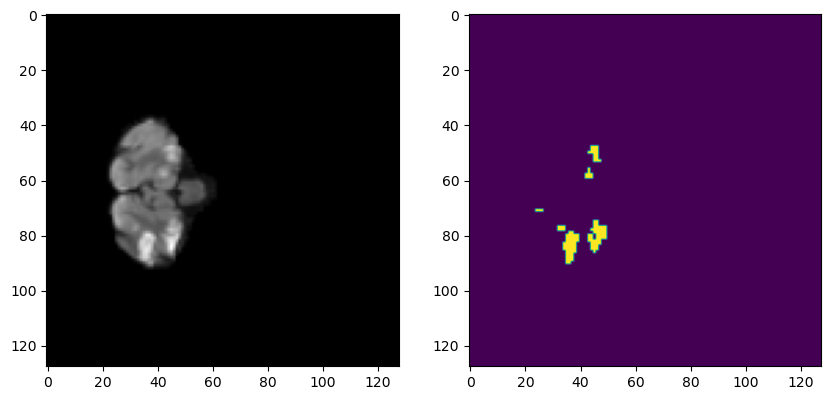

In [15]:
plt.figure(figsize=(10, 10)) 
plt.subplot(1, 2, 1)
plt.imshow(data_dicts[300]["image"][0, :, :], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(data_dicts[300]["label"][0, :, :])

plt.show()


In [19]:
np.unique(data_dicts[3000]["label"], return_counts=True)

(array([0., 1.]), array([16381,     3], dtype=int64))

In [16]:
len(np.unique(data_dicts[300]["image"]))

1570

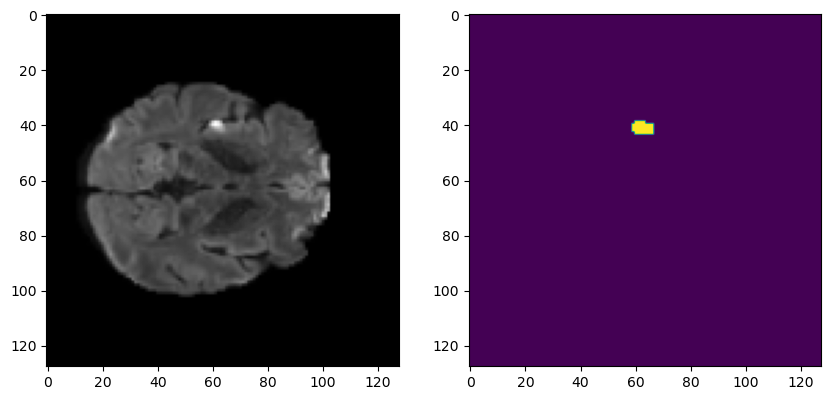

In [17]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(data_dicts[100]["image"][0, :, :], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(data_dicts[100]["label"][0, :, :])

plt.show()

In [18]:
# # calculate class weights
# masks_arr = np.array(masks)
# pos_weight_val = np.sum(masks_arr == 0) / np.sum(masks_arr == 1)
# pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32)
# print("pos_weight: ", pos_weight)

In [19]:
# (masks_arr == 1).sum() / (masks_arr == 0).sum()

In [20]:
# pos_data = extract_pos_slice(data_dict)

In [21]:
# data = data_dict + pos_data * 3

In [22]:
# len(data)

In [23]:
random.seed(42)

In [24]:
data = data_dicts
random.shuffle(data)

In [25]:
# # Split the dataset into training and testing sets
# images_train, images_test, masks_train, masks_test = train_test_split(
#     images, masks, test_size=0.2, random_state=42
# )

In [26]:
data, test_data = data[:int(len(data)*0.8)], data[int(len(data)*0.8):]

In [27]:
len(data), len(test_data)

(3861, 966)

In [28]:
# create 5 folds of cross_validation
from sklearn.model_selection import KFold

# Number of folds for cross-validation
num_CV = 5
kf = KFold(n_splits=num_CV, shuffle=True, random_state=42)

# Lists to store training and validation sets for each fold
train_files, val_files = [], []

# Loop through the folds
for train_index, val_index in kf.split(data):

    train_data, val_data = [data[i] for i in train_index], [data[i] for i in val_index]

    # Append the training and validation sets to the lists
    train_files.append(train_data)
    val_files.append(val_data)

In [29]:
train_transforms = Compose(
    [
            RandAffined(
             keys=['image', 'label'],
             mode=('bilinear', 'nearest'),
             prob=0.2, spatial_size=(128, 128),
             rotate_range=(0, 0, np.pi/15),
             scale_range=(0.1, 0.1, 0.1),
            translate_range=(0.1, 0.1, 0.1),
            padding_mode='border'),
            ToTensord(keys=["image", "label"], dtype=torch.float32),
    ]
)

val_transforms = Compose(
    [
        ToTensord(keys=["image", "label"], dtype=torch.float32),
    ]
)

In [30]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

In [31]:
image_sample, label_sample = (check_data["image"][0][0], check_data["label"][0][0])
torch.sum(label_sample).item()

67.0

torch.Size([773, 3, 128, 128])
image shape: torch.Size([128, 128]), label shape: torch.Size([128, 128])


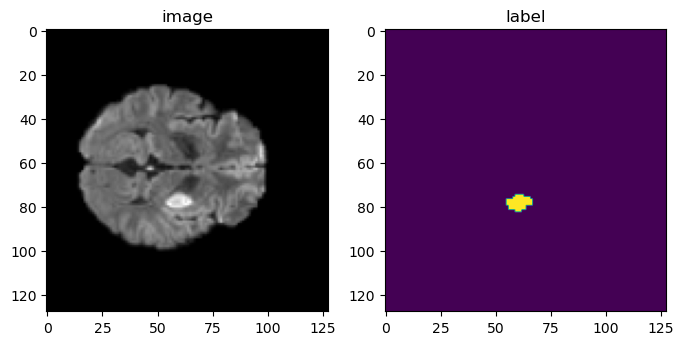

In [32]:

print(check_data["image"].shape)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

# unique_values, counts = torch.unique(label, return_counts=True)
# print(unique_values, counts)
# print(sum(counts[1:]))
# plot the slice [:, :, 50]
plt.figure("check", (8,6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:,:], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :])
plt.show()

### Training

In [35]:
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv_block(nn.Module):
    def __init__(self, ch_in, ch_out) -> None:
        """
        conv_block: Convolutional block with two convolutional layers with batch normalization and ReLU activation.
        no change in size of the image.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,  padding=1),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True))
        
    def forward(self, x):
        return self.conv(x)

    
class Upsample(nn.Module):
    def __init__(self,ch_in,ch_out):
        """
        Upsample: Upsample the image by a factor of 2 and then apply a convolutional layer.
        No change in the size of the image.
        """
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x
    
class UNET(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super().__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2) # reduce the size of the image by half

        self.enc1 = conv_block(ch_in=img_ch,ch_out=64)
        self.enc2 = conv_block(ch_in=64,ch_out=128)
        self.enc3 = conv_block(ch_in=128,ch_out=256)
        self.enc4 = conv_block(ch_in=256,ch_out=512)
        
        self.bottle_neck = conv_block(ch_in=512, ch_out=1024)

        self.Upconv4 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) # increase the size of the image by 2 and decrease the number of channels by half
        self.dec4 = conv_block(ch_in=1024, ch_out=512)
        
        self.UpConv3 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.dec3 = conv_block(ch_in=512,ch_out=256)
        
        self.UpConv2 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.dec2 = conv_block(ch_in=256,ch_out=128)
        
        self.UpConv1 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.dec1 = conv_block(ch_in=128,ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self, x):
        # x: B, img_ch, H, W
        
        
        # encoding path
        e1 = self.enc1(x)  # B, 64, H, W
        
        e2 = self.enc2(self.Maxpool(e1))  # B, 128, H/2, W/2
        e3 = self.enc3(self.Maxpool(e2))  # B, 256, H/4, W/4
        e4 = self.enc4(self.Maxpool(e3)) # B, 512, H/8, W/8
        
        bottle_neck = self.bottle_neck(self.Maxpool(e4)) # B, 1024, H/16, W/16
        
        d4 = self.Upconv4(bottle_neck) # B, 512, H/8, W/8
        d4 = torch.cat((d4, e4), dim=1) # B, 1024, H/8, W/8
        d4 = self.dec4(d4) # B, 512, H/8, W/8
        
        d3 = self.UpConv3(d4) # B, 256, H/4, W/4
        d3 = torch.cat((d3,e3),dim=1) # B, 512, H/4, W/4
        d3 = self.dec3(d3) # B, 256, H/4, W/4
        
        d2 = self.UpConv2(d3) # B, 128, H/2, W/2
        d2 = torch.cat((d2,e2),dim=1) # B, 256, H/2, W/2
        d2 = self.dec2(d2) # B, 128, H/2, W/2
        
        d1 = self.UpConv1(d2) # B, 64, H, W
        d1 = torch.cat((d1,e1),dim=1) # B, 128, H, W
        d1 = self.dec1(d1) # B, 64, H, W
        
        out = self.Conv_1x1(d1) # B, output_cha, H, W
        out = F.softmax(out,dim=1)
class ResNetUNet(nn.Module):
    def __init__(self, output_ch=1):
        super().__init__()
        
        # Use a pretrained ResNet34 model but remove the fully connected layer and the final pooling layer
        self.resnet = models.resnet34(pretrained=True)
        self.resnet_layers = list(self.resnet.children())[:-2]
        self.resnet_encoder = nn.Sequential(*self.resnet_layers)

        # Encoder channels based on ResNet34 architecture
        enc_chs = [64, 64, 128, 256, 512]
        
        # Decoder components
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = conv_block(ch_in=512, ch_out=256)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(ch_in=256, ch_out=128)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(ch_in=128, ch_out=64)
        
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(ch_in=128, ch_out=64)

        self.conv1x1 = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Encoder path
        x1 = self.resnet_encoder[0](x)
        x2 = self.resnet_encoder[1](x1)
        x3 = self.resnet_encoder[4](x2)
        x4 = self.resnet_encoder[5](x3)
        x5 = self.resnet_encoder[6](x4)
        
        # Decoder path
        d4 = self.upconv4(x5)
        d4 = torch.cat((d4, x4), dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, x3), dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, x2), dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, x1), dim=1)
        d1 = self.dec1(d1)
        
        out = self.conv1x1(d1)
        out = F.softmax(out, dim=1)

        return out

In [36]:
device = torch.device("cuda:0") 
loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)
# loss_function2 = smp.losses.FocalLoss(mode="binary", alpha=0.9, gamma=2.0)

# Create the UNet model with the specified backbone
# model = smp.Unet(
#     encoder_name="resnet34",
#     in_channels=3,
#     classes=1, 
#     activation="sigmoid", 
# ).to(device)
from custom_model import CustomModel
# model = CustomModel(
#         channels = [64, 128, 256, 512],
#         scale = [4, 2, 2, 2],
#         num_blocks = [2, 2, 2, 2],
#         num_heads = [2, 4, 8, 16],
#         mlp_hidden = [256, 512, 1024, 2048],
#         dropout = 0.0,                     # change to dropout rate=0.2 
#         decoder_hidden = 256,
#         attention=False,
#     ).to(device)
model = ResNetUNet(output_ch=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True


c:\Users\frank\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\frank\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\frank/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 82.1MB/s]


In [37]:
root_dir = "output/"

In [38]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []


num_CV = 5
max_epochs = 100
epoch_per_CV = max_epochs // num_CV

for i in range(num_CV):

    print("-" * 10)
    print(f"Fold {i}")
    train_ds = Dataset(data=train_files[i], transform=train_transforms)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
    val_ds = Dataset(data=val_files[i], transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=32, num_workers=4)

    if i < num_CV - 1:
        start_epoch = i * epoch_per_CV
        end_epoch = (i + 1) * epoch_per_CV
    else:
        start_epoch = i * epoch_per_CV
        end_epoch = max_epochs

    for epoch in range(start_epoch, end_epoch):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")

        # Training
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in tqdm(train_loader, desc="Training"):
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # Validation
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_iou = 0.0
            num_batches = len(val_loader)

            with torch.no_grad():
                for val_data in tqdm(val_loader, desc="Validation"):
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )

                    val_outputs = model(val_inputs)
                    val_outputs = (val_outputs > 0.5).float()  # Assuming sigmoid activation

                    # Calculate Dice for the batch
                    intersection = torch.sum(val_outputs * val_labels)
                    union = torch.sum(val_outputs) + torch.sum(val_labels) - intersection
                    iou = (intersection + 1e-15) / (union + 1e-15)
                    val_iou += iou.item()

            # Calculate average IoU across all batches
            average_val_iou = val_iou / num_batches
            metric_values.append(average_val_iou)

            if average_val_iou > best_metric:
                best_metric = average_val_iou
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current mean IoU: {average_val_iou:.4f}"
                f"\nbest mean IoU: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
Fold 0
----------
epoch 1/100


Training:   0%|          | 0/97 [00:31<?, ?it/s]


RuntimeError: Given transposed=1, weight of size [512, 256, 2, 2], expected input[32, 256, 16, 16] to have 512 channels, but got 256 channels instead

In [52]:
best_metric, best_metric_epoch

(0.8266724181175232, 94)

In [ ]:
# # plot Iou and loss curve 
# plt.subplot(1 , 2, 1)
# plt.title("loss curve")
# plt.plot()
# plt.xlabel("epoch")


In [53]:
test_ds = Dataset(data=test_data, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=8, num_workers=4)


In [70]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
metrics = []
with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        # roi_size = (64, 64, 64)
        # roi_size = (128, 128)
        # sw_batch_size = 4
        val_outputs = model(val_data["image"].to(device))

        val_outputs = (val_outputs > 0.5).float()
        val_outputs = val_outputs.detach().cpu()
         # Calculate Dice for the batch
        intersection = torch.sum(val_outputs* val_data["label"])
        union = torch.sum(val_outputs) + torch.sum(val_data["label"]) - intersection
        print(union.item())
        iou = (intersection + 1e-15) / (union + 1e-15)
        
        metrics.append(iou.item())

        # for j in range(10):
        # if i >= 0 and i < 30:
        #     plt.figure("check", (6, 6))
        #     plt.subplot(1, 3, 1)
        #     plt.title(f"image {i}")
        #     plt.imshow(val_data["image"][5, 0, :, :], cmap="gray")
        #     plt.subplot(1, 3, 2)
        #     plt.title(f"label {i}")
        #     plt.imshow(val_data["label"][5, 0, :, :])
        #     plt.subplot(1, 3, 3)
        #     plt.title(f"output {i}")
        #     plt.imshow(val_outputs[5, 0, :, :])
        #     plt.show()


        # if i == 41:
        #     break

1639.0
5881.0
1625.0
2324.0
1892.0
1738.0
1449.0
683.0
1796.0
1734.0
1207.0
1384.0
1625.0
910.0
606.0
3760.0
2350.0
1022.0
950.0
2709.0
2111.0
441.0
1592.0
1014.0
798.0
3093.0
2085.0
998.0
1266.0
1823.0
2411.0
978.0
729.0
1624.0
1367.0
516.0
1201.0
1991.0
596.0
578.0
1607.0
1606.0
795.0
1068.0
1350.0
2261.0
1982.0
1420.0
834.0
1280.0
1505.0
1071.0
1451.0
962.0
637.0
527.0
3222.0
1276.0
1352.0
1437.0
1444.0
2876.0
2100.0
1458.0
1632.0
446.0
1399.0
2343.0
2864.0
2193.0
1146.0
1913.0
2804.0
620.0
345.0
1175.0
1752.0
1362.0
135.0
707.0
1484.0
496.0
2130.0
2336.0
2661.0
3064.0
2607.0
1501.0
462.0
2383.0
884.0
4056.0
625.0
2214.0
924.0
1514.0
1799.0
285.0
538.0
626.0
3075.0
2389.0
3265.0
1677.0
615.0
1963.0
3607.0
2857.0
2171.0
3125.0
913.0
1823.0
464.0
1357.0
834.0
459.0
416.0
966.0
446.0
1760.0
845.0


In [71]:
metric_values = np.array(metrics)
metric_values.mean()

0.7687762517574405

In [58]:
metrics = np.array(metrics)
metrics

array([2.52515101, 8.27993774, 2.65750003, 3.61141801, 3.33259416,
       2.24361157, 2.46822023, 0.85923755, 3.50119901, 2.42463231,
       2.50243902, 1.89339018, 3.20240974, 1.82025313, 1.14111924,
       3.48773837, 2.78843236, 1.74477959, 2.07397962, 4.30350208,
       3.55952382, 0.51363635, 2.26901674, 1.88089335, 1.94101119,
       3.89242435, 3.63834429, 2.00496268, 2.00699306, 3.36784148,
       4.73318386, 1.73111117, 0.90289259, 2.52087474, 2.06653619,
       1.06476688, 2.43705463, 2.65805173, 1.14690721, 1.05994546,
       3.04474282, 3.14672685, 1.40093243, 1.35609758, 2.210145  ,
       3.60515881, 4.20560741, 2.68693686, 1.93150687, 2.34382033,
       2.43721962, 2.42857146, 2.86500001, 1.21681416, 1.33506489,
       1.02173913, 4.19435215, 2.74514556, 1.73523426, 2.32034636,
       3.0147059 , 5.12992144, 3.1832993 , 2.4924407 , 3.26450109,
       0.9348442 , 2.75413704, 4.18918896, 4.51252413, 3.44612479,
       1.86711717, 3.50833344, 3.59903383, 1.02721083, 0.64627